In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/the-uyghur-voice-cup/sample.csv
/kaggle/input/the-uyghur-voice-cup/train.csv
/kaggle/input/the-uyghur-voice-cup/test.csv
/kaggle/input/the-uyghur-voice-cup/wavs/48fd599cba044955ad3b6f872affb24a.wav
/kaggle/input/the-uyghur-voice-cup/wavs/435011e406944f2b8c8a9af159a71cdf.wav
/kaggle/input/the-uyghur-voice-cup/wavs/a453fb3fdd8a4eb992d291b6249333a1.wav
/kaggle/input/the-uyghur-voice-cup/wavs/86e91f31fafd460eb1a74966c56dbca3.wav
/kaggle/input/the-uyghur-voice-cup/wavs/58f4c7508bac4a29a9a0540e689e6da4.wav
/kaggle/input/the-uyghur-voice-cup/wavs/badedfdd048c4db99556c16a73ef36dc.wav
/kaggle/input/the-uyghur-voice-cup/wavs/1900fe920e0a4df7a9c873c4543af811.wav
/kaggle/input/the-uyghur-voice-cup/wavs/c791efeeec7a437f89582c046fed69c6.wav
/kaggle/input/the-uyghur-voice-cup/wavs/3657ca7194244e898c843da007b973c8.wav
/kaggle/input/the-uyghur-voice-cup/wavs/37965824f5b54424b87b71efe4446b0f.wav
/kaggle/input/the-uyghur-voice-cup/wavs/40faaf21c9494a11b2d6d002f7fbe127.wav
/kaggle/input/the-

In [2]:
from datasets import load_dataset

training_data=load_dataset("csv",data_files="/kaggle/input/the-uyghur-voice-cup/train.csv")
test_data=load_dataset("csv", data_files="/kaggle/input/the-uyghur-voice-cup/test.csv")

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

In [3]:
training_data=training_data["train"]

In [4]:
test_data=test_data['train']

In [5]:
training_data[0]['transcription']

'vuyGur HAlqiniN fevudal bAglArniN wA pomexciklar sinipiniN hOkUmranliqidiki jAbir japaliq turmuxini vAks vAttUridiGan qoxaqlar bar'

In [6]:
%%capture
!pip install evaluate jiwer
!pip install datasets==3.6.0
!pip install fsspec==2023.9.2
!pip install transformers==4.52.0

In [7]:
import torch
import evaluate
import numpy as np
from dataclasses import dataclass, field
from typing import Any, Dict, List, Optional, Union
from transformers import WhisperFeatureExtractor, WhisperTokenizer, WhisperProcessor

2025-07-28 11:33:35.919957: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753702416.108348      18 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753702416.163856      18 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [8]:
feature_extractor=WhisperFeatureExtractor.from_pretrained("openai/whisper-tiny", task="transcribe")
tokenizer=WhisperTokenizer.from_pretrained("openai/whisper-tiny", task="transcribe")
processor=WhisperProcessor.from_pretrained("openai/whisper-tiny", task='transcribe')

preprocessor_config.json: 0.00B [00:00, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

normalizer.json: 0.00B [00:00, ?B/s]

added_tokens.json: 0.00B [00:00, ?B/s]

special_tokens_map.json: 0.00B [00:00, ?B/s]

In [9]:
training_data

Dataset({
    features: ['ID', 'filepath', 'transcription'],
    num_rows: 7574
})

In [10]:
training_data[0]['filepath']

'wavs/aca14f95f3c4487fa955a9360e324ca5.wav'

In [11]:
import torchaudio
import torchaudio.transforms as T
def load_resample_audio(batch):
    batch["filepath"]="/kaggle/input/the-uyghur-voice-cup/"+batch['filepath']
    waveform, sr=torchaudio.load(batch['filepath'])

    if sr!=16000:
        resampler = T.Resample(orig_freq=sample_rate, new_freq=16000)
        waveform = resampler(waveform)

    batch["audio"] = {
        "array": waveform.squeeze().numpy(),
        "sampling_rate": 16000
    }

    return batch


In [12]:
train_data=training_data.map(load_resample_audio,batch_size=8)

Map:   0%|          | 0/7574 [00:00<?, ? examples/s]

In [13]:
test_data=test_data.map(load_resample_audio, batch_size=8)

Map:   0%|          | 0/1894 [00:00<?, ? examples/s]

In [14]:
split_data=train_data.train_test_split(test_size=0.2, seed=42)
train_data=split_data["train"]
val_data=split_data["test"]

In [15]:
train_data[0]

{'ID': '462809202eff43478c0a003c55a57c3e',
 'filepath': '/kaggle/input/the-uyghur-voice-cup/wavs/462809202eff43478c0a003c55a57c3e.wav',
 'transcription': 'vAhwal hAqiqAtAn murAkkAp jAzmAn tApsiliy tAkxUrgAndin keyin vandin yAkUn ciqarGili bolidu',
 'audio': {'array': [0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0

## Plotting audio array to check leading silences

In [16]:
import matplotlib.pyplot as plt

def plot_audio_array(dataset, index):
    audio = dataset[index]["audio"]["array"]

    plt.figure(figsize=(14, 4))
    plt.plot(audio)
    plt.title(f"Waveform at index {index}")
    plt.xlabel("Time (samples)")
    plt.ylabel("Amplitude")
    plt.show()


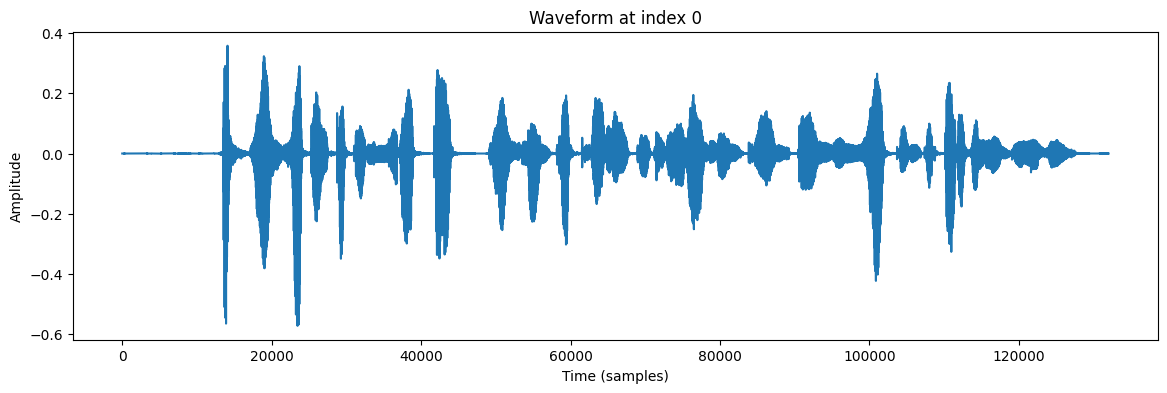

In [17]:
plot_audio_array(train_data,0)

## Adding audio duration column

In [18]:
def add_audio_duration(batch):
    array = batch["audio"]["array"]
    sr = batch["audio"]["sampling_rate"]
    batch["duration"] = len(array) / sr
    return batch

train_data = train_data.map(add_audio_duration)
val_data=val_data.map(add_audio_duration)


Map:   0%|          | 0/6059 [00:00<?, ? examples/s]

Map:   0%|          | 0/1515 [00:00<?, ? examples/s]

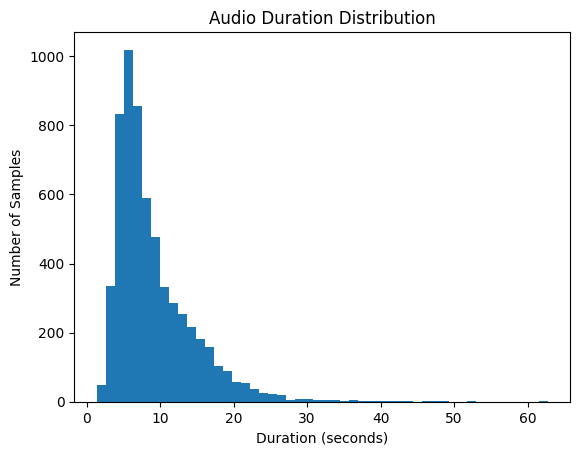

In [19]:
import matplotlib.pyplot as plt

durations = train_data["duration"]

plt.hist(durations, bins=50)
plt.title("Audio Duration Distribution")
plt.xlabel("Duration (seconds)")
plt.ylabel("Number of Samples")
plt.show()


## Filtering larger samples

In [20]:
train_data_filtered=train_data.filter(lambda x:x['duration']<=30.0)
val_data_filtered=val_data.filter(lambda x:x['duration']<=30.0)

Filter:   0%|          | 0/6059 [00:00<?, ? examples/s]

Filter:   0%|          | 0/1515 [00:00<?, ? examples/s]

## Adding silence duration to check how much silence

In [21]:
def add_silence_duration(batch, threshold=1e-4):
    waveform = batch["audio"]["array"]
    sr = batch["audio"]["sampling_rate"]

    # Detect first non-silent sample
    for i, val in enumerate(waveform):
        if abs(val) > threshold:
            silence_sec = i / sr
            break
    else:
        silence_sec = len(waveform) / sr  # entire audio is silent

    batch["leading_silence"] = round(silence_sec, 3)
    return batch


In [22]:
train_data_filtered=train_data_filtered.map(add_silence_duration,batch_size=8)
val_data_filtered=val_data_filtered.map(add_silence_duration,batch_size=8)

Map:   0%|          | 0/6014 [00:00<?, ? examples/s]

Map:   0%|          | 0/1506 [00:00<?, ? examples/s]

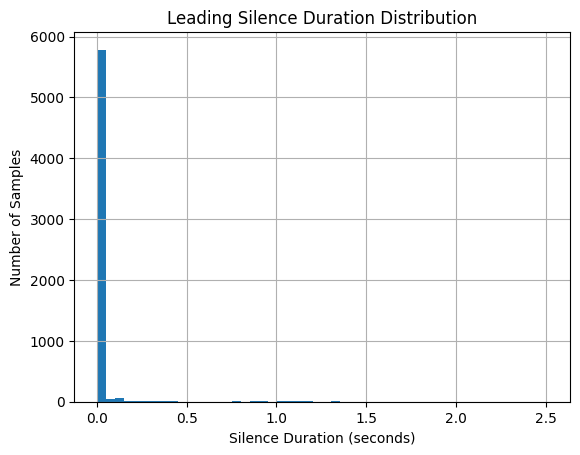

In [23]:
leading_silences = train_data_filtered["leading_silence"]
plt.hist(leading_silences, bins=50)
plt.title("Leading Silence Duration Distribution")
plt.xlabel("Silence Duration (seconds)")
plt.ylabel("Number of Samples")
plt.grid(True)
plt.show()

## Trimming the silences

In [24]:
# !pip install librosa
# import librosa 
# import numpy as np

In [25]:
# def trim_only_leading(batch):
#     waveform = batch["audio"]["array"]
#     sr = batch["audio"]["sampling_rate"]
#     _, (start, _) = librosa.effects.trim(waveform, top_db=20)
#     trimmed = waveform[start:]
#     batch["audio"]["array"] = trimmed
#     return batch


In [26]:
# train_data_filtered=train_data
# val_data_filtered=val_data

In [27]:
def prepare_batch(batch):
    audio=batch["audio"]
    batch["input_features"]=processor(audio["array"], sampling_rate=16000).input_features[0]
    batch["input_length"]=len(batch['input_features'])


    batch["labels"]=tokenizer(batch["transcription"]).input_ids
    return batch

train_dataset=train_data_filtered.map(prepare_batch, batch_size=8)
val_dataset=val_data_filtered.map(prepare_batch, batch_size=8)

Map:   0%|          | 0/6014 [00:00<?, ? examples/s]

Map:   0%|          | 0/1506 [00:00<?, ? examples/s]

In [28]:
from transformers import WhisperForConditionalGeneration

model=WhisperForConditionalGeneration.from_pretrained("openai/whisper-tiny")
model.config.task = "transcribe"
model.config.forced_decoder_ids = None

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/151M [00:00<?, ?B/s]

generation_config.json: 0.00B [00:00, ?B/s]

In [29]:
@dataclass
class DataCollatorWhisperWithPadding:
  processor: WhisperProcessor
  padding: Union[bool,str]=True

  def __call__(self, features: List[Dict[str,Any]]) -> Dict[str, torch.Tensor]:
    input_features=[{"input_features":f["input_features"]} for f in features]

    batch=self.processor.feature_extractor.pad(
        input_features,
        padding=self.padding,
        return_tensors="pt"
    )
    if "labels" in features[0]:
            label_features = [{"input_ids": f["labels"]} for f in features]
            labels_batch = self.processor.tokenizer.pad(
                label_features,
                padding=self.padding,
                return_tensors="pt"
            )
            labels = labels_batch["input_ids"].masked_fill(
                labels_batch.attention_mask.ne(1), -100
            )
            batch["labels"] = labels
    return batch


In [30]:
data_collator=DataCollatorWhisperWithPadding(processor=processor, padding=True)

In [31]:
cer_metric=evaluate.load("cer")

def compute_metrics(pred):
    pred_logits = pred.predictions
    pred_ids = np.argmax(pred_logits, axis=-1)

    pred.label_ids[pred.label_ids == -100] = processor.tokenizer.pad_token_id

    pred_str = processor.batch_decode(pred_ids)
    # we do not want to group tokens when computing the metrics
    label_str = processor.batch_decode(pred.label_ids, group_tokens=False)

    cer = cer_metric.compute(predictions=pred_str, references=label_str)

    return {"cer": cer}

In [32]:
from transformers import Seq2SeqTrainingArguments

training_args = Seq2SeqTrainingArguments(
    #output_dir="./whisper-small-hi",  # change to a repo name of your choice
    per_device_train_batch_size=1,
    per_device_eval_batch_size=1,
    gradient_accumulation_steps=4,  # increase by 2x for every 2x decrease in batch size
    learning_rate=5e-5,
    warmup_steps=200,
    weight_decay=0.01,
    num_train_epochs=3,
    ##max_steps=10,
    gradient_checkpointing=True,
    fp16=True,
    ##eval_strategy="steps",
    predict_with_generate=True,
    generation_max_length=225,
    save_steps=200,
    save_total_limit=2,
    ##eval_steps=100,
    logging_steps=25,
    logging_strategy="steps",
    report_to=["tensorboard"],
    ##load_best_model_at_end=True,
    metric_for_best_model="cer",
    greater_is_better=False,
    remove_unused_columns=False
)



In [33]:
from transformers import Seq2SeqTrainer

trainer = Seq2SeqTrainer(
    args=training_args,
    model=model,
    train_dataset=train_dataset,
    ##eval_dataset=val_dataset,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    tokenizer=processor
)

/tmp/ipykernel_18/387431447.py:3: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(


In [34]:
evaluation=trainer.train()

Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.43.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.
Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.43.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.
`use_cache = True` is incompatible with gradient checkpointing. Setting `use_cache = False`...
`use_cache = True` is incompatible with gradient checkpointing. Setting `use_cache = False`...
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss
25,5.161400
50,3.057500
75,2.054400
100,1.600700
125,1.299400
150,1.257400
175,1.102400
200,1.026400
225,0.968300
250,0.867600


/usr/local/lib/python3.11/dist-packages/transformers/modeling_utils.py:3464: UserWarning: Moving the following attributes in the config to the generation config: {'max_length': 448, 'suppress_tokens': [1, 2, 7, 8, 9, 10, 14, 25, 26, 27, 28, 29, 31, 58, 59, 60, 61, 62, 63, 90, 91, 92, 93, 359, 503, 522, 542, 873, 893, 902, 918, 922, 931, 1350, 1853, 1982, 2460, 2627, 3246, 3253, 3268, 3536, 3846, 3961, 4183, 4667, 6585, 6647, 7273, 9061, 9383, 10428, 10929, 11938, 12033, 12331, 12562, 13793, 14157, 14635, 15265, 15618, 16553, 16604, 18362, 18956, 20075, 21675, 22520, 26130, 26161, 26435, 28279, 29464, 31650, 32302, 32470, 36865, 42863, 47425, 49870, 50254, 50258, 50358, 50359, 50360, 50361, 50362], 'begin_suppress_tokens': [220, 50257]}. You are seeing this warning because you've set generation parameters in the model config, as opposed to in the generation config.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gath

In [35]:
model.save_pretrained("/kaggle/working/whisper-finetuned")
processor.save_pretrained("/kaggle/working/whisper-finetuned")


[]

In [36]:
import shutil

shutil.make_archive("/kaggle/working/whisper-finetuned", 'zip', "/kaggle/working/whisper-finetuned")


'/kaggle/working/whisper-finetuned.zip'

In [37]:
eval_results = trainer.evaluate(eval_dataset=val_dataset)
print(f"Validation CER: {eval_results['eval_cer']:.4f}")


Due to a bug fix in https://github.com/huggingface/transformers/pull/28687 transcription using a multilingual Whisper will default to language detection followed by transcription instead of translation to English.This might be a breaking change for your use case. If you want to instead always translate your audio to English, make sure to pass `language='en'`.
The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Validation CER: 1.0000


In [38]:
eval_results

{'eval_loss': 0.312981516122818,
 'eval_cer': 0.9999545619201122,
 'eval_runtime': 874.6098,
 'eval_samples_per_second': 1.722,
 'eval_steps_per_second': 0.861,
 'epoch': 3.0}

In [39]:
def remove_special_tokens(text: str) -> str:
    special_tokens = [
        "<|startoftranscript|>", "<|notimestamps|>", "<|transcribe|>", "<|endoftext|>"
    ]
    for token in special_tokens:
        text = text.replace(token, "")
    return text.strip()


In [40]:
from transformers import WhisperProcessor
import numpy as np

val_preds = trainer.predict(val_dataset)
print(val_preds)

PredictionOutput(predictions=array([[10119,  9505,   590, ..., 50257, 50257, 50257],
       [ 2558,    72,    45, ..., 50257, 50257, 50257],
       [   73,   706,  2312, ..., 50257, 50257, 50257],
       ...,
       [ 6021,  9505,   302, ..., 50257, 50257, 50257],
       [   85, 24307,    45, ..., 50257, 50257, 50257],
       [32257,  1323,    65, ..., 50257, 50257, 50257]]), label_ids=array([[50258, 50359, 50363, ..., 50257, 50257, 50257],
       [50258, 50359, 50363, ..., 50257, 50257, 50257],
       [50258, 50359, 50363, ..., 50257, 50257, 50257],
       ...,
       [50258, 50359, 50363, ..., 50257, 50257, 50257],
       [50258, 50359, 50363, ..., 50257, 50257, 50257],
       [50258, 50359, 50363, ..., 50257, 50257, 50257]]), metrics={'test_loss': 0.312981516122818, 'test_cer': 0.9999545619201122, 'test_runtime': 880.8939, 'test_samples_per_second': 1.71, 'test_steps_per_second': 0.855})


In [41]:
val_preds[1][0]

array([50258, 50359, 50363, 10119,  9505,   590,  3722,    45,   710,
        4727,  1607,   532, 24307,    45, 13775,    75,  8021,    38,
          64, 33497,   647,   350, 18684,  5843,  3812,   371,    46,
         372,  1770,    67,    32,   350,   501, 13432,   259,   459,
       14610, 44824,    80,   282,  2992,    39,    83, 10683, 13642,
         276,    32,  2174,   327,   259,  2779,   409,   350, 21520,
        4504, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257,
       50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257,
       50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257,
       50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257,
       50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257,
       50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257,
       50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257,
       50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257,
       50257, 50257,

In [42]:
cleaned_labels=[]
for i in range(len(val_preds[1])):
    ids=val_preds[1][i]
    true=[]
    for id in ids:
        if id!=50258 and id!=50359 and id!=50363 and id!=50257:
            true.append(id)
    decoded=tokenizer.decode(true)
    ##print(decoded)
    ##cleaned_preds = [remove_special_tokens(p) for p in decoded]
    cleaned_labels.append(decoded)

In [43]:
cleaned_preds=[]
for i in range(len(val_preds[0])):
    ids=val_preds[0][i]
    true=[]
    for id in ids:
        if id!=50258 and id!=50359 and id!=50363 and id!=50257:
            true.append(id)
    decoded=tokenizer.decode(true)
    ##print(decoded)
    ##cleaned_preds = [remove_special_tokens(p) for p in decoded]
    cleaned_preds.append(decoded)

In [44]:
first_pred=cleaned_preds[0]
first_label=cleaned_labels[0]

In [45]:
count=0
for i in range(len(cleaned_preds)):
    if cleaned_preds[i]==cleaned_labels[i]:
        count+=1

In [46]:
count

180

In [47]:
test_data

Dataset({
    features: ['ID', 'filepath', 'audio'],
    num_rows: 1894
})

In [48]:
def prepare_test_batch(batch):
    audio=batch["audio"]
    batch["input_features"]=processor(audio["array"], sampling_rate=16000).input_features[0]
    batch["input_length"]=len(batch['input_features'])
    return batch

test_dataset=test_data.map(prepare_test_batch)

Map:   0%|          | 0/1894 [00:00<?, ? examples/s]

In [49]:
predictions=trainer.predict(test_dataset)

In [50]:
len(predictions[0])

1894

In [51]:
cleaned_labels=[]
for i in range(len(predictions[0])):
    ids=predictions[0][i]
    true=[]
    for id in ids:
        if id!=50258 and id!=50359 and id!=50363 and id!=50257:
            true.append(id)
    decoded=tokenizer.decode(true)
    ##print(decoded)
    ##cleaned_preds = [remove_special_tokens(p) for p in decoded]
    cleaned_labels.append(decoded)

In [52]:
test_data

Dataset({
    features: ['ID', 'filepath', 'audio'],
    num_rows: 1894
})

In [53]:
submission=[]
for i in range(len(cleaned_labels)):
    vals={}
    
    vals["ID"]=test_data[i]['ID']
    vals["transcription"]=cleaned_labels[i]
    submission.append(vals)

In [54]:
submission

[{'ID': 'f068a206b84c4632865e0629a1b62fb8',
  'transcription': 'bu dorini helila qaynatqan caqqan bol visisqida viciwalGin'},
 {'ID': 'a9d8cfab47b34f12b8f4b4769075713e',
  'transcription': 'yamGurdin keyinki hawa Huddi sUzUp tazilarniGandAk vintayin sap bolidu'},
 {'ID': '34147b4f995144288b720d7474ba4dd6',
  'transcription': 'qar barGancA qattiq yaGdi yoldiki piyadilAr teHimu xalaNxip kAtti'},
 {'ID': 'c6c201bcd81a402385c2f008983f7474',
  'transcription': 'cAtkA ciqip bilim vigAnligAndin keyin qaytip kelimAn tAxkilniN maNa bolGan vixAncisini hArgiz yArdA qoymaymAn'},
 {'ID': 'c3c190cc67c14d4a946ef1b722196248',
  'transcription': 'vAyiplAx kixini cUxkUnlAxtUridu vilhamlandurux kixini rohlanduridu'},
 {'ID': '5a01e615c7474244a173f684403c9bb8',
  'transcription': 'kOpcilik kOzlirini cAkcAytip voqutquci vixlAwatqan tAjribini qiziqip kOrmAktA vidi'},
 {'ID': '9b19c7e026574657a5245b5b5ee4e1c8',
  'transcription': 'xad Huramliq naHxa sadasi mAktAp vasminida vuzaqqicA yaNridi'},
 {'ID': '3bd71

In [55]:
import pandas as pd
df=pd.DataFrame(submission)
df.to_csv('submission.csv', index=False)

In [56]:
df

,ID,transcription
0,f068a206b84c4632865e0629a1b62fb8,bu dorini helila qaynatqan caqqan bol visisqid...
1,a9d8cfab47b34f12b8f4b4769075713e,yamGurdin keyinki hawa Huddi sUzUp tazilarniGa...
2,34147b4f995144288b720d7474ba4dd6,qar barGancA qattiq yaGdi yoldiki piyadilAr te...
3,c6c201bcd81a402385c2f008983f7474,cAtkA ciqip bilim vigAnligAndin keyin qaytip k...
4,c3c190cc67c14d4a946ef1b722196248,vAyiplAx kixini cUxkUnlAxtUridu vilhamlandurux...
...,...,...
1889,32bed9ca13524a29b3c7e26d6eb22388,bUgUn yazGucilar vix cinHua kitabHanisida voqu...
1890,3353cc9d9abc4bf193e0c407d5a7aa0f,vu bir roman yezixqa tAyyarlandi hazir materiy...
1891,85a9d2787c554b05af6312a50062344d,kambodJya dOlAt zAhAr cAklAx vapparatiniN vAmA...
1892,37b66b00798441adb2662106d569221a,kixilAr bekAttA vOcUrAt turup maxiniGa ciqixni...
